In [4]:
import pandas as pd
from pathlib import Path
import numpy as np

nao_folder = Path('/home/nikolenko/work/janpa_done')

def read_populations(input_file):
    with open(input_file, 'r') as inp:
        lines = [line.strip() for line in inp.readlines()]
        start = lines.index('charge\t population\t  population\tcharge')
        populations = []
        charges = []
        i = 1
        while len(lines[start + i]) > 0:
            line = lines[start + i]
            populations.append([line.split()[0], float(line.split()[2])])
            charges.append(float(line.split()[4]))
            i += 1
    return {'populations': populations, 'charges': charges}

def calc_indexes(minus, zero, plus):
    negative = [val for val in minus['charges']]
    neutral = [val for val in zero['charges']]
    positive = [val for val in plus['charges']]
    
    return negative, neutral, positive

def process_mol(filename):
    minus_file = filename + '-1.out'
    neutral_file = filename + '0.out'
    plus_file = filename + '1.out'

    neg_charges, neutral_charges, pos_charges = calc_indexes(
        minus=read_populations(minus_file),
        zero=read_populations(neutral_file),
        plus=read_populations(plus_file)
    )
    
    return neg_charges, neutral_charges, pos_charges

def check_mol_list(input_folder):
    files = list(input_folder.glob('*_conformation_optimized_*'))
    base_names = {f.stem[:-2] for f in files}
    valid_files = [name for name in base_names if all((input_folder / (name + suffix)).exists() for suffix in ['-1.out', '0.out', '1.out'])]
    return valid_files

def calculate_cdd(row):
    return [2 * hc - hfe - hfn for hc, hfe, hfn in zip(row['hirshfeld_charges'], row['hirshfeld_fukui_elec'], row['hirshfeld_fukui_neu'])]

def calculate_log_cdd(cdd_values):
    return [np.log10(abs(value)) if value != 0 else np.nan for value in cdd_values]

def rmse(series):
    return np.sqrt(np.mean(series**2))

def process_all_mols(input_folder):
    files_list = check_mol_list(input_folder)
    combined_data = []

    for file in files_list:
        try:
            neg_charges, neutral_charges, pos_charges = process_mol(str(input_folder / file))
            base_name = file.split('_')[0]  # Извлекаем название молекулы (цифры до _)
            conf_number = int(file.split('_')[3])  # Номер конформации как целое число
            combined_data.append({
                'Molecule': base_name,
                'Conformation': conf_number,
                'hirshfeld_charges': neg_charges,
                'hirshfeld_fukui_elec': neutral_charges,
                'hirshfeld_fukui_neu': pos_charges
            })
        except ValueError:
            print(f'Broken file: {file}')
            continue

    combined_df = pd.DataFrame(combined_data)
    combined_df = combined_df.sort_values(by=['Molecule', 'Conformation'])
    combined_df['CDD'] = combined_df.apply(calculate_cdd, axis=1)
    combined_df['Log_CDD'] = combined_df['CDD'].apply(calculate_log_cdd)
    
    # Группировка по молекулам и расчет RMSE для каждой молекулы и ее конформеров
    grouped = combined_df.groupby('Molecule')
    
    rmse_results = []
    for molecule, group in grouped:
        rmse_hirshfeld_charges = rmse(pd.Series(np.concatenate(group['hirshfeld_charges'].values)))
        rmse_hirshfeld_fukui_elec = rmse(pd.Series(np.concatenate(group['hirshfeld_fukui_elec'].values)))
        rmse_hirshfeld_fukui_neu = rmse(pd.Series(np.concatenate(group['hirshfeld_fukui_neu'].values)))
        rmse_results.append({
            'Molecule': molecule,
            'RMSE_hirshfeld_charges': rmse_hirshfeld_charges,
            'RMSE_hirshfeld_fukui_elec': rmse_hirshfeld_fukui_elec,
            'RMSE_hirshfeld_fukui_neu': rmse_hirshfeld_fukui_neu
        })
    
    rmse_df = pd.DataFrame(rmse_results)
    
    
    return combined_df, rmse_df

combined_df, rmse_df = process_all_mols(input_folder=nao_folder)

Broken file: 50770_conformation_optimized_4_


In [5]:
combined_df

,Molecule,Conformation,hirshfeld_charges,hirshfeld_fukui_elec,hirshfeld_fukui_neu,CDD,Log_CDD
763,11912,2,"[-0.8328368871, 0.5788824669, -0.8364176159, -...","[-0.7904237058, 0.5775246483, -0.8350919605, -...","[-0.7541737204, 0.5672330754, -0.8225331821, -...","[-0.12107634800000011, 0.013007210099999944, -...","[-0.9169406870495196, -1.8858158447225923, -1...."
615,11912,3,"[-0.8292215009, 0.5679183521, -0.83810306, -0....","[-0.7896504539, 0.5779680971, -0.8343226009, -...","[-0.7427028135, 0.5668231064, -0.82014178, -0....","[-0.12608973440000004, -0.00895449930000003, -...","[-0.8993202700876205, -2.047958693156822, -1.6..."
626,12149,0,"[-0.5921010727, -0.2125531186, -0.5928916186, ...","[-0.5922353134, -0.2149126776, -0.5940200654, ...","[-0.5967331196, -0.2153853267, -0.595513798, -...","[0.004766287599999974, 0.0051917670999999666, ...","[-2.3218197556688422, -2.284684797997657, -2.4..."
587,12149,1,"[-0.6073014295, -0.2139855303, -0.5909325852, ...","[-0.6036356112, -0.2159291861, -0.5926209025, ...","[-0.6090814427, -0.2091436768, -0.5985050578, ...","[-0.0018858051000000264, -0.002898197699999993...","[-2.7245031940845785, -2.537871992539606, -2.0..."
689,12149,2,"[-0.5991128342, -0.2259256802, -0.6151157903, ...","[-0.5999157229, -0.212508695, -0.5932151976, -...","[-0.6040844303, -0.2049871707, -0.5989736966, ...","[0.005774484799999868, -0.03435549470000002, -...","[-2.238486757496124, -1.4640037934792547, -1.4..."
...,...,...,...,...,...,...,...
644,9565,0,"[-0.6123078574, -0.3346664488, -0.4740255543, ...","[-0.649640622, -0.0656906333, -0.3465069518, 0...","[-0.6664399761, 0.0129720505, -0.390788232, 0....","[0.09146488329999991, -0.6166143148000001, -0....","[-1.0387456154020016, -0.20998639727657742, -0..."
616,9565,1,"[-0.6194335715, -0.3333473648, -0.4817751983, ...","[-0.6580872799, -0.0678600991, -0.3436591852, ...","[-0.6754383445, 0.01393858, -0.3890040141, 0.6...","[0.0946584814, -0.6127732105, -0.2308871972999...","[-1.0238404671709036, -0.21270022964559143, -0..."
123,9565,2,"[-0.6199557486, -0.3294645918, -0.4638181921, ...","[-0.6566620011, -0.0758060076, -0.3417929646, ...","[-0.6746378943, 0.0130204843, -0.3892752917, 0...","[0.09138839819999989, -0.5961436603, -0.196568...","[-1.0391089346549305, -0.22464907019702152, -0..."
100,9565,3,"[-0.6102815015, -0.3351803985, -0.4596310132, ...","[-0.6469695287, -0.0674512226, -0.3450533121, ...","[-0.663427313, 0.0076651441, -0.3916244639, 0....","[0.08983383869999995, -0.6105747184999999, -0....","[-1.0465600420354508, -0.21426118209312595, -0..."


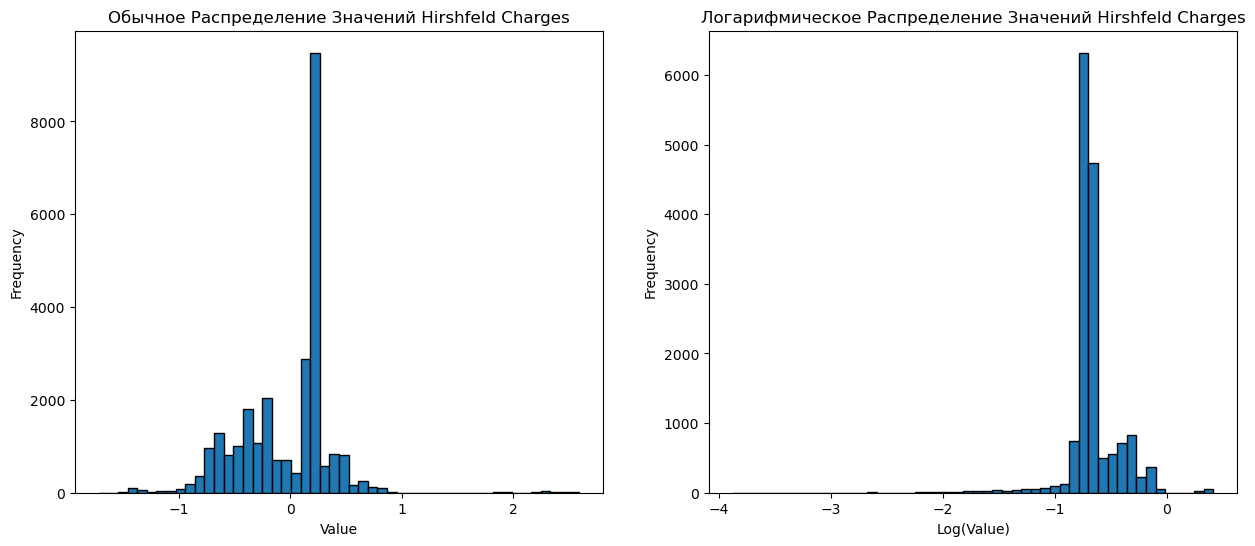

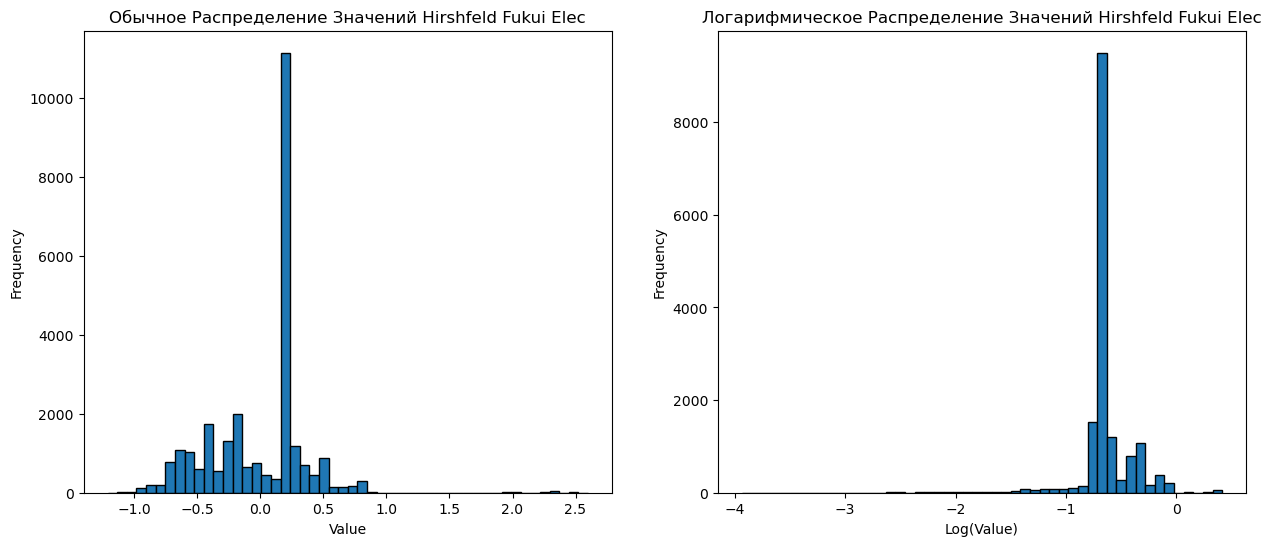

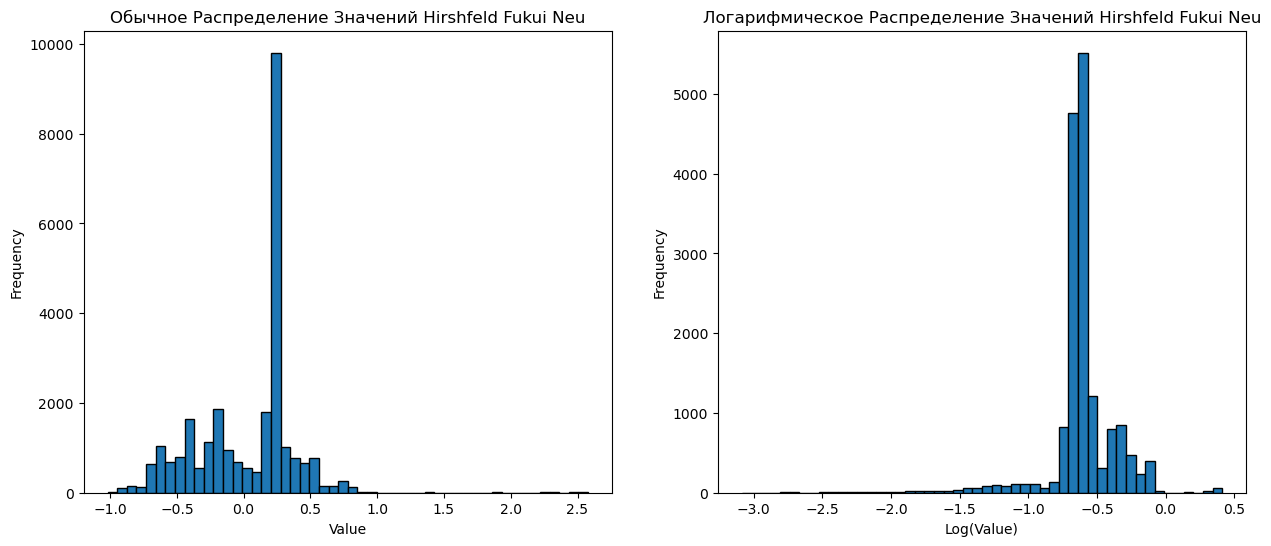

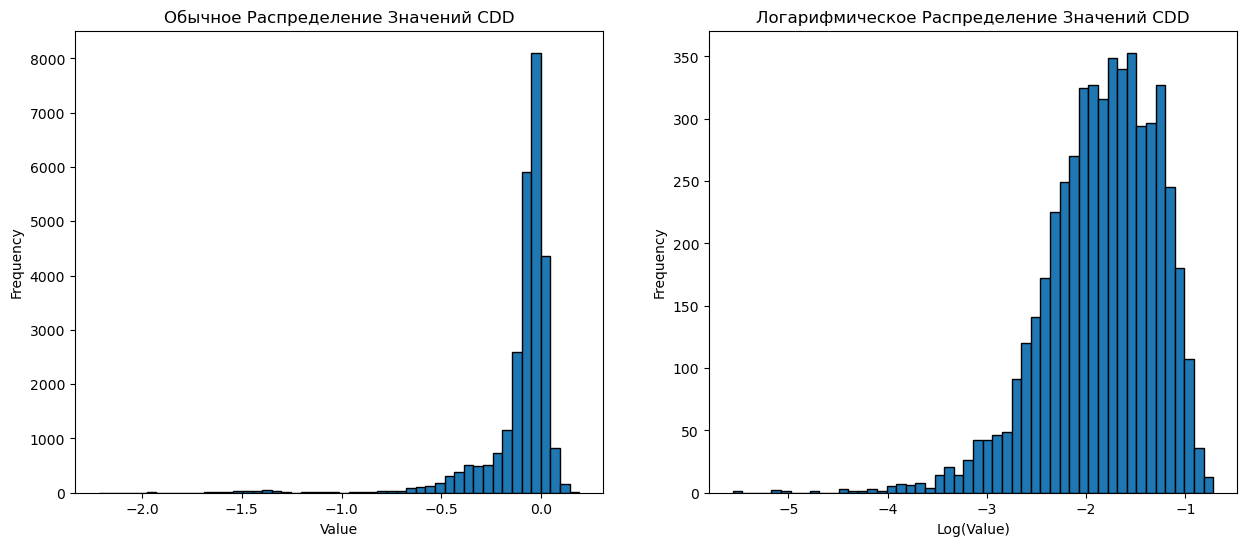

In [6]:
import matplotlib.pyplot as plt

def plot_subgraphs(values, title, bins=50):
    values = pd.Series(values).dropna() 
    values_log = values[values > 0].apply(np.log10) 

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].hist(values, bins=bins, edgecolor='black')
    axs[0].set_title('Обычное ' + title)
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(values_log, bins=bins, edgecolor='black')
    axs[1].set_title('Логарифмическое ' + title)
    axs[1].set_xlabel('Log(Value)')
    axs[1].set_ylabel('Frequency')

    plt.show()



hirshfeld_charges = combined_df['hirshfeld_charges'].explode().astype(float)
hirshfeld_fukui_elec = combined_df['hirshfeld_fukui_elec'].explode().astype(float)
hirshfeld_fukui_neu = combined_df['hirshfeld_fukui_neu'].explode().astype(float)
CDD = combined_df['CDD'].explode().astype(float)

plot_subgraphs(hirshfeld_charges, 'Распределение Значений Hirshfeld Charges')
plot_subgraphs(hirshfeld_fukui_elec, 'Распределение Значений Hirshfeld Fukui Elec')
plot_subgraphs(hirshfeld_fukui_neu, 'Распределение Значений Hirshfeld Fukui Neu')
plot_subgraphs(CDD, 'Распределение Значений CDD')



In [12]:
new_df = combined_df[['Molecule', 'Conformation', 'Log_CDD']].rename(columns={'Log_CDD': 'CDD'})

In [14]:
new_df

,Molecule,Conformation,CDD
763,11912,2,"[-0.9169406870495196, -1.8858158447225923, -1...."
615,11912,3,"[-0.8993202700876205, -2.047958693156822, -1.6..."
626,12149,0,"[-2.3218197556688422, -2.284684797997657, -2.4..."
587,12149,1,"[-2.7245031940845785, -2.537871992539606, -2.0..."
689,12149,2,"[-2.238486757496124, -1.4640037934792547, -1.4..."
...,...,...,...
644,9565,0,"[-1.0387456154020016, -0.20998639727657742, -0..."
616,9565,1,"[-1.0238404671709036, -0.21270022964559143, -0..."
123,9565,2,"[-1.0391089346549305, -0.22464907019702152, -0..."
100,9565,3,"[-1.0465600420354508, -0.21426118209312595, -0..."


In [15]:
new_df.to_csv('data/extended_CDD.csv', index=False)